In [3]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import requests
from pathlib import Path
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

### >

In [4]:
n_samples = 1000

# create circles
X, y = make_circles(n_samples, 
                    noise=0.03,
                    random_state=42)

In [5]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


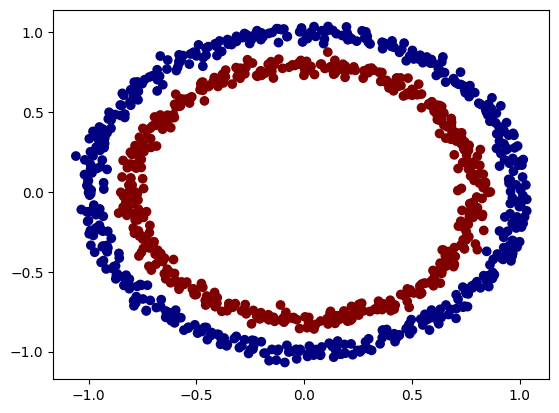

In [6]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='jet')

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## Building a Model

In [12]:
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # create 2 nn.Linear layers capable of handling shapes of the data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)


    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_2( self.layer_1(x))

    #     self.two_linear_layers = nn.Sequential(
    #         nn.Linear(in_features=2, out_features=5),
    #         nn.Linear(in_features=5, out_features=1)
    #     )

    # def forward(self, x:torch.Tensor) -> torch.Tensor:
    #     return self.two_linear_layers(x)
    
# instantiate the model class and send it to gpu
model_0 = CircleModelV1().to(device)        

In [13]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [14]:

# replicate model using nn.Sequential

model_0 = nn.Sequential( # no need to create a forward method but still not recommended for a more complex forward propagation or layers
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3143, -0.5049],
                      [ 0.6793, -0.1899],
                      [ 0.6394, -0.5049],
                      [-0.3484, -0.6519],
                      [ 0.3687, -0.3286]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6252,  0.0993,  0.5077, -0.0439,  0.0304], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3901, -0.3429, -0.2797, -0.2663, -0.2908]], device='cuda:0')),
             ('1.bias', tensor([-0.0685], device='cuda:0'))])

In [16]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f'len of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}')
    print(f'len of test samples: {len(X_test)}, shape: {X_test.shape}')
    print("preds[:10]:\n", torch.round(untrained_preds[:10])) 
    print("labes[:10]:\n", y_test[:10])

len of predictions: 200, shape: torch.Size([200, 1])
len of test samples: 200, shape: torch.Size([200, 2])
preds[:10]:
 tensor([[ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [-1.],
        [-1.],
        [-0.],
        [-0.],
        [ 0.],
        [ 1.]], device='cuda:0')
labes[:10]:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Loss, Optimizer

* Loss  
Linear - MAE (mean absolute error) MSE (mean squared error)  
Cat - cross entrophy etc

In [17]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1) # built-in sigmoid actication function

"""
 ^ same as: 
     nn.Sequential(  
        nn.Sigmoid(),  
        nn.BCELoss()  
    ) 
""" 

'\n ^ same as: \n     nn.Sequential(  \n        nn.Sigmoid(),  \n        nn.BCELoss()  \n    ) \n'

In [18]:
# calculate accuracy

def accuracy_fn(y_true, y_pred) -> float: 
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [19]:
# view logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[ 0.6671],
        [ 0.6393],
        [ 0.1762],
        [ 0.8086],
        [-0.7188]], device='cuda:0')

In [20]:
# use sigmoid to logit to make a round() logit (prediction probability) and compare it into y_test (label)

y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='cuda:0')

In [21]:
# prediction probability values rounding rulw
# threshold = 0.5 (class 1) default value 

# find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels=  torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze() # remove extra dimensions

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0')

## logits -> pre probs -> pred labels

In [22]:
# training, test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    ## Training
    model_0.train()
    
    # forward propagation
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate the loss

    # loss = loss_fn(torch.sigmoid(y_logits), y_train) - this one if use bce for loss

    loss = loss_fn(y_logits, y_train) # bcelogitsloss expect bce(only) as an input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward() # back propagation
    optimizer.step() # gradient descent


    ## Testing    
    model_0.eval()
    with torch.inference_mode():
       # forward pass
       test_logits = model_0(X_test).squeeze()
       test_pred = torch.round(torch.sigmoid(test_logits))

       #calculate the loss
       test_loss = loss_fn(test_logits, y_test)
       test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print 

    if epoch % 10 == 0:
        print(f"epoch: {epoch}, acc: {acc:.2f} % | test loss: {test_loss:.5f}, test acc: {test_acc:.2f} %")

    

epoch: 0, acc: 50.25 % | test loss: 0.73498, test acc: 50.00 %
epoch: 10, acc: 50.12 % | test loss: 0.72325, test acc: 50.50 %
epoch: 20, acc: 50.25 % | test loss: 0.71579, test acc: 50.00 %
epoch: 30, acc: 50.50 % | test loss: 0.71079, test acc: 50.00 %
epoch: 40, acc: 50.75 % | test loss: 0.70730, test acc: 50.00 %
epoch: 50, acc: 50.62 % | test loss: 0.70477, test acc: 50.50 %
epoch: 60, acc: 50.25 % | test loss: 0.70290, test acc: 51.50 %
epoch: 70, acc: 50.50 % | test loss: 0.70148, test acc: 50.50 %
epoch: 80, acc: 50.62 % | test loss: 0.70038, test acc: 49.50 %
epoch: 90, acc: 50.75 % | test loss: 0.69952, test acc: 48.50 %


## make predictions and evaluate model

model not learning  
make visual to see the problem

In [23]:
# dowload helper functions if not yet downlaoded

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    print('Downloading helper_functions.py')
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with  open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists


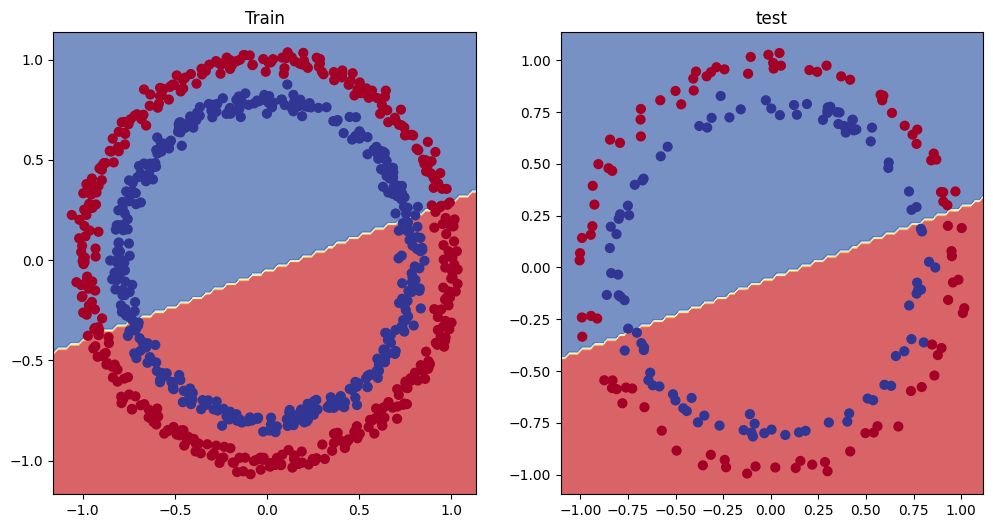

In [24]:
# plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

# for testing data
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

In [25]:
class BiggerCircleModelV1(nn.Module): 
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(x)
        # z = self.layer_3(x)
        return self.layer_3(self.layer_2(self.layer_1(x))) # line-wise, speed, comfort reason this. 
    
model_1 = BiggerCircleModelV1().to(device)
model_1

BiggerCircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
# lossfn, optim

loss_fn1 = nn.BCEWithLogitsLoss()
optimizer1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [27]:
# train, eval loop
torch.manual_seed(42)
epochs = 1000 

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    #training

    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calc loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calc loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0: print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 200 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 300 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 400 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 500 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 600 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 700 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 800 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 900 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%


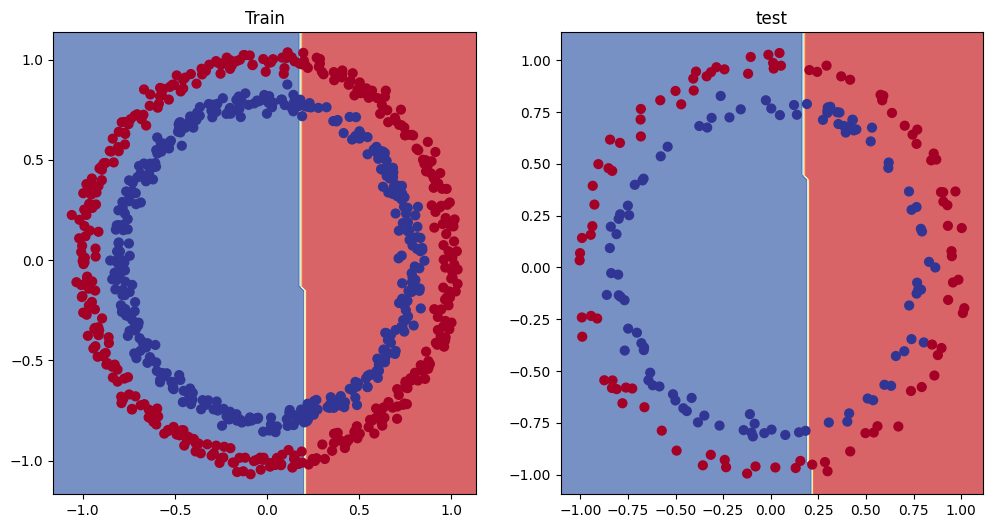

In [28]:
# plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

# for testing data
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)

In [29]:
# Preparing data to see if model can fit a regression line
#(1)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [30]:
# (2)

train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

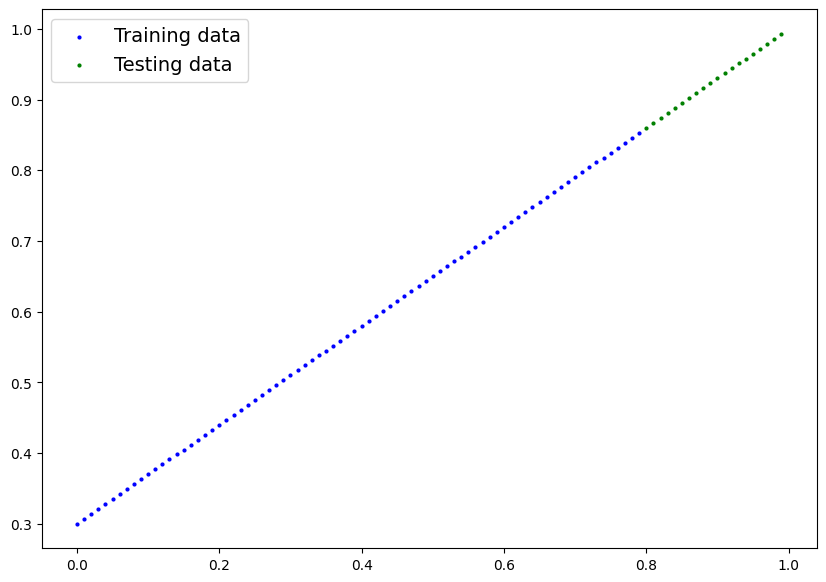

In [31]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [32]:
# same architecture but using nn.Sequential

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
loss_fn2 = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [34]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn2(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
      test_pred = model_2(X_test_regression)
      test_loss = loss_fn2(test_pred, y_test_regression)

    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Train loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798, Test loss: 0.00360


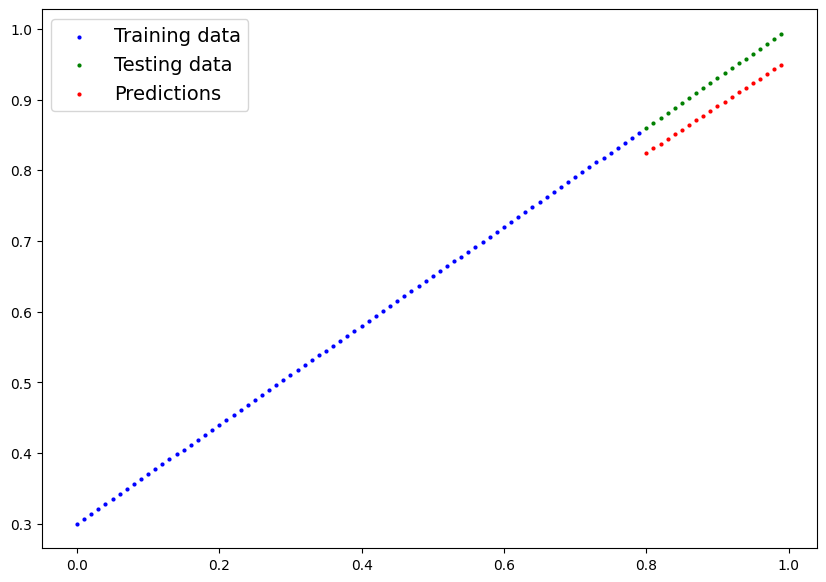

In [35]:
# turn on evaluation
model_2.eval()

# make predictions(inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

    plot_predictions(train_data=X_train_regression.cpu(),
                     train_labels=y_train_regression.cpu(),
                     test_data=X_test_regression.cpu(),
                     test_labels=y_test_regression.cpu(),
                     predictions=y_preds.cpu())

## 11:51 Recreating a non-linear data

### create new samples

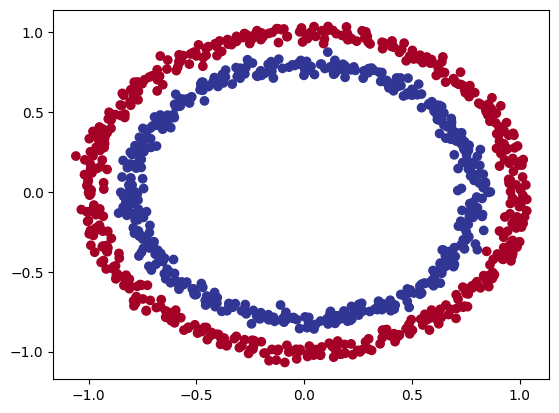

In [36]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdYlBu')

### splitting

In [37]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model with non-linear actication function

In [38]:
import torch
from torch import nn

class CircleModelV2(nn.Module): 
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()


    def forward(self, x):
        # where to put non-linear activation function?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

### Loss function, optimizer

In [39]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

### train model3 with non-linearity

In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epoch = 1000

# device agnostic code
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
    # training
    model_3.train()

    # forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # calc loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Test
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # print(test_logits.shape, y_test.shape)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print
    if epoch % 100 == 0:
        print(f"epoch: {epoch}, loss: {loss:.4f}, test_loss: {test_loss:3f}%, acc: {acc:.4f}, test_acc: {test_acc:.2f}%")



epoch: 0, loss: 0.6929, test_loss: 0.693188%, acc: 50.0000, test_acc: 50.00%
epoch: 100, loss: 0.6912, test_loss: 0.691024%, acc: 52.8750, test_acc: 52.50%
epoch: 200, loss: 0.6898, test_loss: 0.689396%, acc: 53.3750, test_acc: 55.00%
epoch: 300, loss: 0.6879, test_loss: 0.687232%, acc: 53.0000, test_acc: 56.00%
epoch: 400, loss: 0.6852, test_loss: 0.684115%, acc: 52.7500, test_acc: 56.50%
epoch: 500, loss: 0.6810, test_loss: 0.679412%, acc: 52.7500, test_acc: 56.50%
epoch: 600, loss: 0.6751, test_loss: 0.672851%, acc: 54.5000, test_acc: 56.00%
epoch: 700, loss: 0.6666, test_loss: 0.663216%, acc: 58.3750, test_acc: 59.00%
epoch: 800, loss: 0.6516, test_loss: 0.647569%, acc: 64.0000, test_acc: 67.50%
epoch: 900, loss: 0.6236, test_loss: 0.621453%, acc: 74.0000, test_acc: 79.00%


### Evaluate non-linear model with reLU activation fn

In [41]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_preds[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'))

### Plot decision boundaries

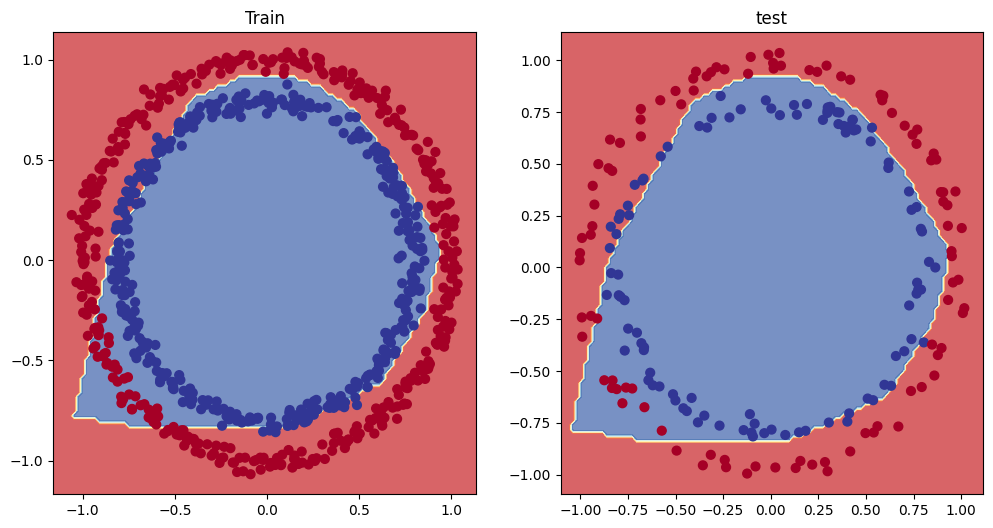

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_3, X_test, y_test)

### Replicating non-linear __activation fn__ (tools we give models for it to discover patterns)

In [43]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

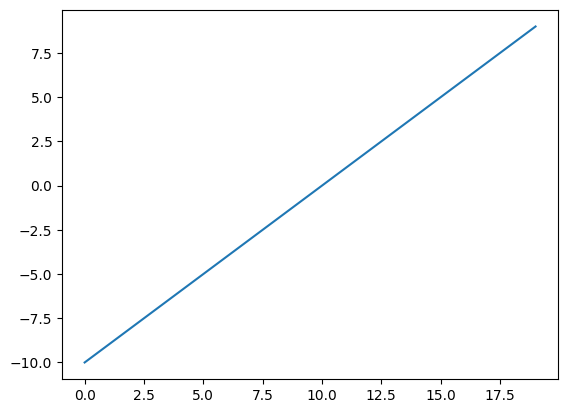

In [44]:
plt.plot(A)

#### reLU

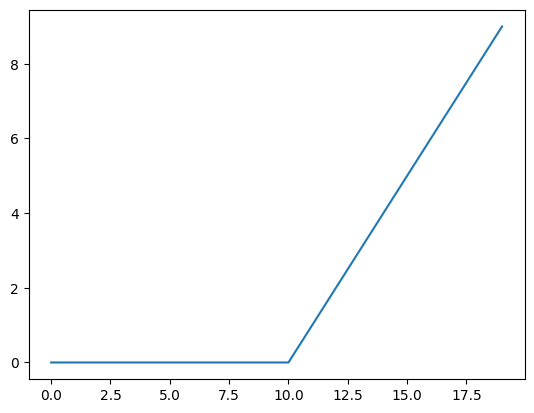

In [45]:
plt.plot(torch.relu(A))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

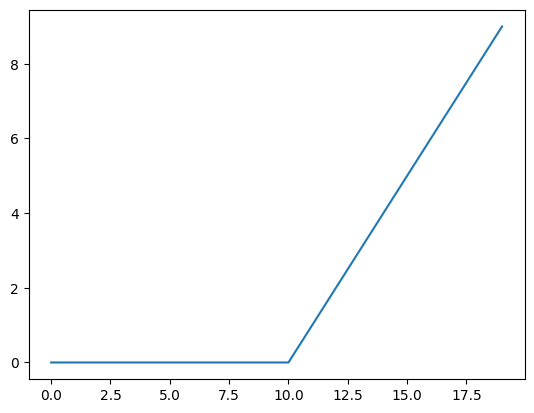

In [46]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))
relu(A)

#### Sigmoid

In [47]:
def sigmoid(x):
    return 1 / (1+torch.exp(-x))

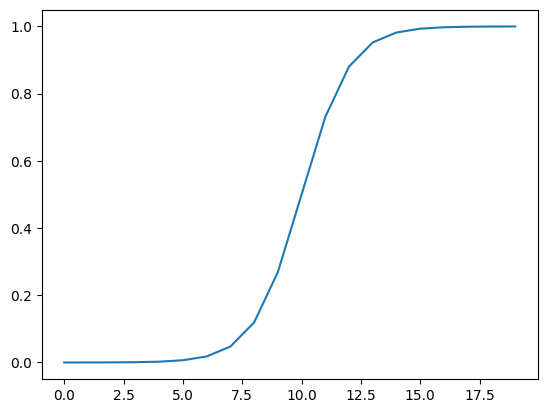

In [48]:
plt.plot(torch.sigmoid(A))

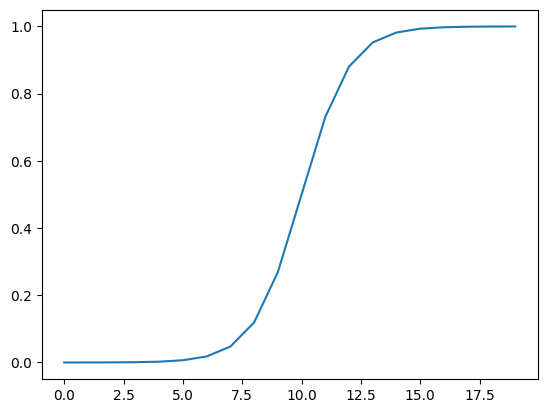

In [49]:
plt.plot(sigmoid(A))

In [50]:
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

### Putting it all together

#### toy multi-class dataset

In [51]:
from sklearn.datasets import make_blobs

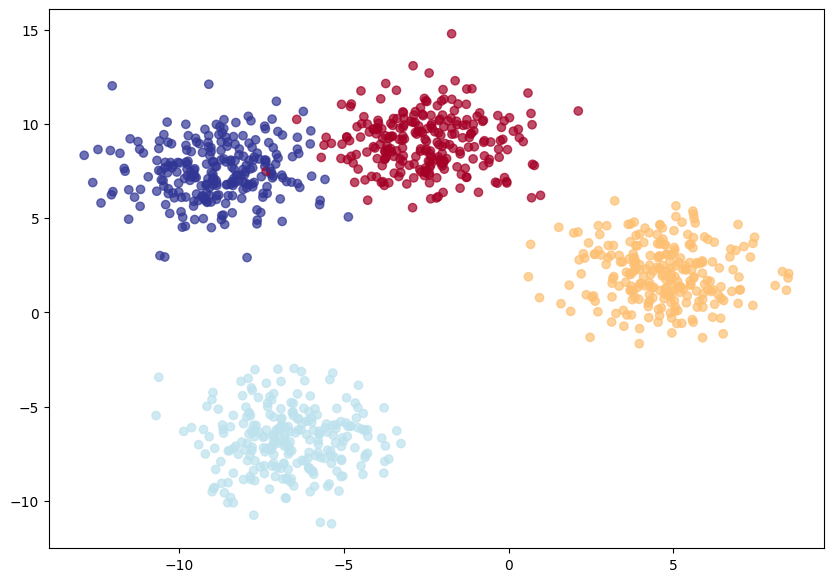

In [52]:
# hyperparameters (convention: capitalized)

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                              n_features=NUM_FEATURES,
                              centers = NUM_CLASSES,
                              cluster_std=1.5,
                              random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# splitting
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                         test_size=0.2,
                                                                         random_state=RANDOM_SEED)

# plot
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap="RdYlBu", alpha=0.7)

#### multi-class pytorch model

In [53]:
# multiclass classification model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Args: 
            input_features (int): num of input features (classes)
            output_features (int): num of output features (classes)
            hidden_units (int): num of hidden_units(layers), default 8

        Returns:

        
        Example: 

        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    

# create instance, change device

model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

#### lossfn, optimizer

In [54]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

#### Training loop
* logits -> pred probs -> pred labels

In [55]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_preds[:10] # logits

tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0')

In [56]:
# logits -> pred probs: use activation function

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [57]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [58]:
torch.argmax(y_pred_probs[5])

tensor(0, device='cuda:0')

In [59]:
# prediction prob to pred labels

y_preds = torch.argmax(y_pred_probs, dim=1) 
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### Training, testing loop multi-class, pytorch

In [60]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test= X_blob_test.to(device), y_blob_test.to(device)

epochs = 100

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test.to(device))
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 ==0:
        print(f"epoch: {epoch}, loss:{loss:.4f}, testloss: {test_loss:.4f}, acc: {acc:.2f}, testacc: {test_acc:.2f}")

epoch: 0, loss:1.1588, testloss: 1.0755, acc: 40.38, testacc: 48.00
epoch: 10, loss:0.6448, testloss: 0.6607, acc: 96.75, testacc: 97.50
epoch: 20, loss:0.4254, testloss: 0.4307, acc: 98.50, testacc: 100.00
epoch: 30, loss:0.2529, testloss: 0.2451, acc: 99.12, testacc: 99.50
epoch: 40, loss:0.1123, testloss: 0.1023, acc: 99.25, testacc: 99.50
epoch: 50, loss:0.0663, testloss: 0.0585, acc: 99.25, testacc: 99.50
epoch: 60, loss:0.0507, testloss: 0.0429, acc: 99.25, testacc: 99.50
epoch: 70, loss:0.0430, testloss: 0.0349, acc: 99.25, testacc: 99.50
epoch: 80, loss:0.0384, testloss: 0.0299, acc: 99.25, testacc: 99.50
epoch: 90, loss:0.0352, testloss: 0.0266, acc: 99.25, testacc: 99.50


In [61]:
# evaluating

model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [62]:
# logits -> pred prob

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [63]:
# pred probs -> pred labels 

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

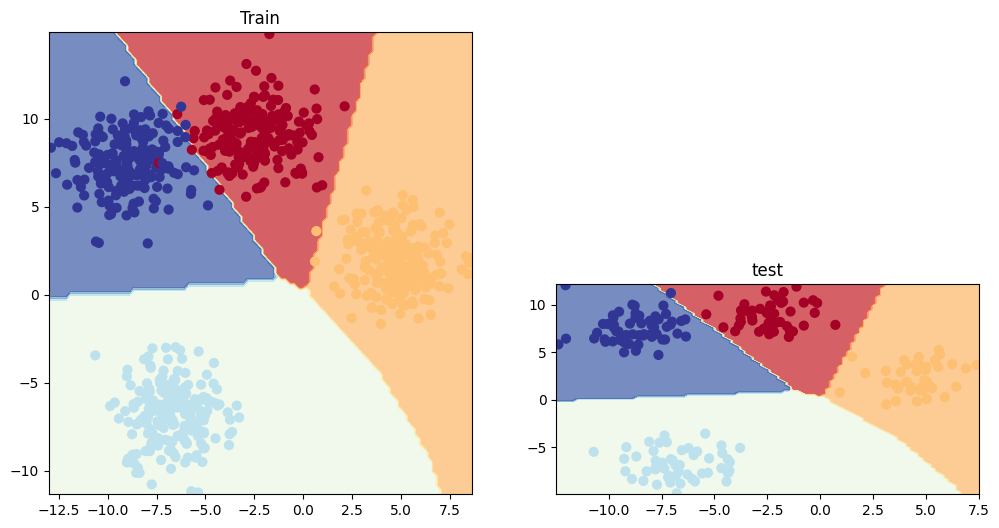

In [64]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(2,2,4)
plt.title("test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# plt.subplot(2,2,4)
# plt.title("sdfsd")
# plot_decision_boundary(model_4, X_blob_test, y_blob_test)



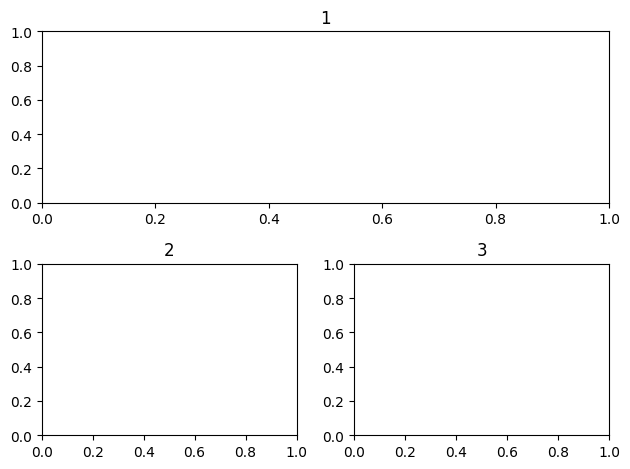

In [65]:
plt.subplot(2, 1, 1)  # Divides the figure into 2 rows, 1 column
plt.title("1") 

# Bottom left subplot
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, position 3
plt.title("2")  


plt.subplot(2, 2, 4)
plt.title("3")
plt.tight_layout()
# plt.subplots_adjust(hspace=0.3)

In [ ]:
from torchmetrics import Accuracy

# torchmetric_accuracy = Accuracy().to(device)

# # calculate acc
# torchmetric_accuracy(y_preds, y_blob_test)

: 